In this script, we use the geemap (https://github.com/giswqs/geemap) module. Map is plotted on notebook onto which a line is drawn. Water occurrence values at 101 equally spaced points are extracted. Similarly elevation values for the same points are interpolated. The two plots are drawn together for comparison of any relations.

In [1]:
# %matplotlib widget
%matplotlib inline
# %matplotlib qt 

import json

import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium
import geopandas as gpd
from shapely.geometry import box, Polygon
from pyproj import CRS
from tqdm.notebook import tqdm
from tqdm import trange

In [2]:
# remove folium warning
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

In [3]:
import ee
import geemap

In [4]:
import seaborn as sb

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from collections import Counter

import scipy
from scipy.interpolate import griddata

In [5]:
df = pd.read_pickle('../data/out/df.pkl')
df2 = pd.read_pickle('../data/out/df2.pkl')
df3 = pd.read_pickle('../data/out/df3.pkl')

In [6]:
df

,track_id,date,beam,series,lon,lat,h,water_occurrence,filter
0,180,2019-01-09,gt3r,Noise,89.622678,23.727912,3.698254,-0.050000,"180, gt3r, Noise"
1,180,2019-01-09,gt3r,Noise,89.622680,23.727912,-30.436510,-0.050000,"180, gt3r, Noise"
2,180,2019-01-09,gt3r,Noise,89.622685,23.727913,-103.526760,-0.050000,"180, gt3r, Noise"
3,180,2019-01-09,gt3r,Noise,89.622679,23.727918,-19.456028,-0.050000,"180, gt3r, Noise"
4,180,2019-01-09,gt3r,Noise,89.622678,23.727918,-9.291720,-0.050000,"180, gt3r, Noise"
...,...,...,...,...,...,...,...,...,...
4150038,1239,2020-03-16,gt1l,High,89.751855,23.721827,-47.611958,-0.049445,"1239, gt1l, High"
4150039,1239,2020-03-16,gt1l,High,89.751852,23.721802,-47.792526,-0.049445,"1239, gt1l, High"
4150040,1239,2020-03-16,gt1l,High,89.751844,23.721725,-47.442990,-0.049841,"1239, gt1l, High"
4150041,1239,2020-03-16,gt1l,High,89.751837,23.721668,-47.488422,-0.049955,"1239, gt1l, High"


In [7]:
df.memory_usage()

Index                    128
track_id            33200344
date                33200344
beam                33200344
series              33200344
lon                 33200344
lat                 33200344
h                   33200344
water_occurrence    33200344
filter              33200344
dtype: int64

<AxesSubplot:>

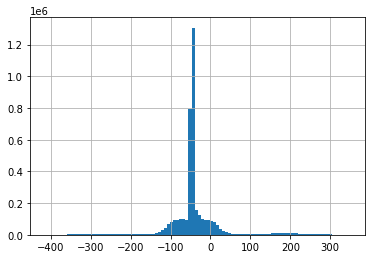

In [8]:
df.h.hist(bins=100)

<AxesSubplot:>

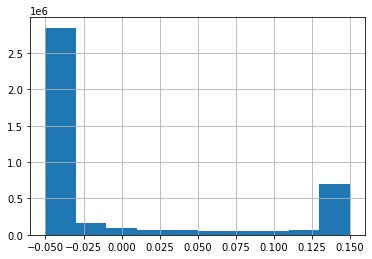

In [9]:
df.water_occurrence.hist(bins=10)

In [10]:
df.track_id.unique()

array(['180', nan, '622', '797', '1239'], dtype=object)

In [11]:
df.date.unique()

array(['2019-01-09', nan, '2019-04-10', '2020-01-07', '2019-02-07',
       '2019-05-08', '2019-08-07', '2019-11-06', '2020-02-05',
       '2020-05-06', '2018-11-19', '2019-02-18', '2019-05-20',
       '2019-11-18', '2020-02-16', '2018-12-18', '2019-03-19',
       '2019-06-18', '2019-09-17', '2019-12-17', '2020-03-16'],
      dtype=object)

In [12]:
df.beam.unique()

array(['gt3r', nan, 'gt3l', 'gt2r', 'gt2l', 'gt1r', 'gt1l'], dtype=object)

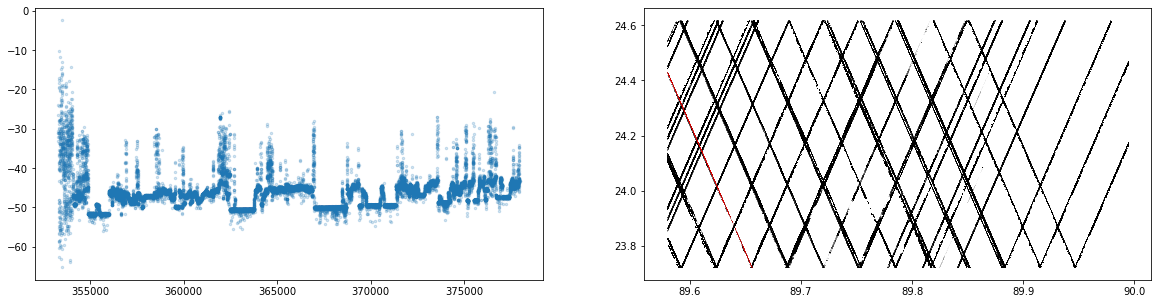

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
# (df.series != 'Noise') & (df.series != 'Buffer') & 
data = df [(df.series != 'Noise') & (df.track_id == '180') & (df.date == '2020-01-07') & (df.beam == 'gt2r')]

ax[0].plot(data.h, '.', markersize=5, alpha=0.2)
ax[1].plot(df.lon, df.lat, 'k.', markersize=0.1, alpha=0.2)
ax[1].plot(data.lon, data.lat, 'r.', markersize=0.1, alpha=0.2)
plt.show()

In [14]:
# Bangladesh
extents = [89.57958670206244, 23.721136875400937, 89.99453684543461, 24.618409448937893] #Extent same as users/gena/AquaMonitor2020/bathymetry-jamuna/bathymetry3-jamuna-2018-2019
zoom = 10

In [15]:
#Map = geemap.Map()
Map = geemap.Map(center=[((23.721136875400937 + 24.618409448937893)/2), ((89.57958670206244 + 89.99453684543461)/2)], zoom=zoom)
#Map = geemap.Map(center(lon = ((89.57958670206244 + 89.99453684543461)/2), lat = ((23.721136875400937 + 24.618409448937893)/2)), zoom = zoom)
Map

Map(center=[24.169773162169413, 89.78706177374852], controls=(WidgetControl(options=['position'], widget=HBox(…

In [19]:
# Add Earth Engine dataset
image = ee.Image('users/gena/AquaMonitor2020/bathymetry-jamuna/bathymetry3-jamuna-2018-2019').select('ndwi')

# Set visualization parameters.
# vis_params = {
#   'min': 0,
#   'max': 4000,
#   'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Add Earth Engine DEM to map
#Map.addLayer(image, vis_params, 'NDWI Jamuna 2019-20')
Map.addLayer(image,name = 'NDWI Jamuna 2019-20', opacity=0.75)

In [20]:
#Here we have added the earth engine dataset.. bathymetry data; perhaps we could add the icesat h data as well here, but how?

In [21]:
Map.draw_features

In [22]:
Map.draw_last_feature

In [23]:
line = Map.draw_last_feature
# print(line)
endpoints = line.getInfo()['geometry']['coordinates']
endpoints

[[89.672598, 24.212317], [89.85391, 24.15469]]

In [24]:
step_x = (endpoints[1][0] - endpoints[0][0])/100
step_y = (endpoints[1][1] - endpoints[0][1])/100
coords = []
lon = [endpoints[0][0]]
lat = [endpoints[0][1]]
for i in range(0,100):
    lon.append(step_x + lon[-1])
    lat.append(step_y + lat[-1])
    
coords = list(zip(lon, lat))

In [25]:
type(coords)

list

In [26]:
#Do we interpolate points or do we draw plots on icesat track lines, that is the question;

In [27]:
df

,track_id,date,beam,series,lon,lat,h,water_occurrence,filter
0,180,2019-01-09,gt3r,Noise,89.622678,23.727912,3.698254,-0.050000,"180, gt3r, Noise"
1,180,2019-01-09,gt3r,Noise,89.622680,23.727912,-30.436510,-0.050000,"180, gt3r, Noise"
2,180,2019-01-09,gt3r,Noise,89.622685,23.727913,-103.526760,-0.050000,"180, gt3r, Noise"
3,180,2019-01-09,gt3r,Noise,89.622679,23.727918,-19.456028,-0.050000,"180, gt3r, Noise"
4,180,2019-01-09,gt3r,Noise,89.622678,23.727918,-9.291720,-0.050000,"180, gt3r, Noise"
...,...,...,...,...,...,...,...,...,...
4150038,1239,2020-03-16,gt1l,High,89.751855,23.721827,-47.611958,-0.049445,"1239, gt1l, High"
4150039,1239,2020-03-16,gt1l,High,89.751852,23.721802,-47.792526,-0.049445,"1239, gt1l, High"
4150040,1239,2020-03-16,gt1l,High,89.751844,23.721725,-47.442990,-0.049841,"1239, gt1l, High"
4150041,1239,2020-03-16,gt1l,High,89.751837,23.721668,-47.488422,-0.049955,"1239, gt1l, High"


In [28]:
verts = df[['lon', 'lat', 'h']]

In [29]:
verts

,lon,lat,h
0,89.622678,23.727912,3.698254
1,89.622680,23.727912,-30.436510
2,89.622685,23.727913,-103.526760
3,89.622679,23.727918,-19.456028
4,89.622678,23.727918,-9.291720
...,...,...,...
4150038,89.751855,23.721827,-47.611958
4150039,89.751852,23.721802,-47.792526
4150040,89.751844,23.721725,-47.442990
4150041,89.751837,23.721668,-47.488422


In [30]:
df = df.dropna()

In [31]:
grid_z = griddata((df.lon, df.lat), df.h, (lon, lat), method='linear')

In [32]:
grid_z

array([ -75.37575438,  -93.47322174,  -90.67150718,  -97.300094  ,
       -111.29540787,  -98.65556435,  -62.80165068,  -51.58264489,
        -54.42682693,  -56.82006723,  -59.21330753,  -66.07582482,
        -61.19547962,  -69.00676343,  -48.51359066,  -32.92972328,
        -15.95125128,  -19.00286552,  -80.97883428, -105.14654283,
       -103.30896161, -103.87057494, -110.72333784, -108.07018151,
        -96.20198565, -198.3627282 , -216.91366852, -227.87111727,
       -242.47184071, -158.69383571, -105.81144665,   -7.89939698,
        103.35866821,   52.99443399,  -22.79540696,    7.33216732,
        -48.91619178,   -8.47883606,  -49.07000861,  -55.24437424,
        -59.17404394,  -62.81136753,  -68.2345485 ,  -70.88636155,
        -67.22445399,  -66.25975658,  -82.18999983,  -84.13711259,
        -82.60877801,  -96.90485037, -101.85662631, -109.45866655,
        -24.59161485,  -49.42429895,  -67.12897612,  -12.19529659,
        -15.63851313,   -5.63366425,  -12.09634771,  -20.67436

In [33]:
results = []

    
features = ee.List(coords).map(lambda o: ee.Feature(ee.Geometry.Point(coords=o)))
#print(features)
features = ee.FeatureCollection(features)
    
values = image.unmask(-999, False).reduceRegions(collection=features, reducer=ee.Reducer.first().setOutputs(['water_occurrence']), scale=10, tileScale=1)
results = results + values.aggregate_array('water_occurrence').getInfo()

In [34]:
x = range(0,101)
y = results

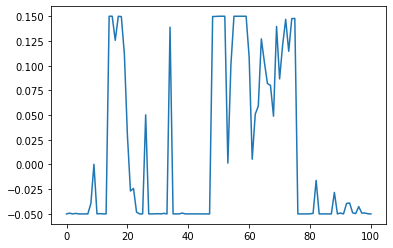

In [35]:
plt.plot(x,y)

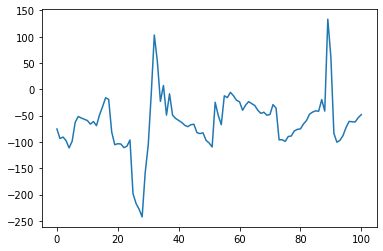

In [36]:
plt.plot(x,grid_z)

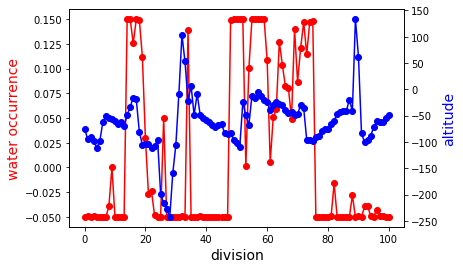

In [42]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(x,y, color="red", marker="o")
# set x-axis label
ax.set_xlabel("division",fontsize=14)
# set y-axis label
ax.set_ylabel("water occurrence",color="red",fontsize=14)





# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(x,grid_z,color="blue",marker="o")
ax2.set_ylabel("altitude",color="blue",fontsize=14)
plt.show()

In [41]:
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(x,grid_z,color="blue",marker="o")
ax2.set_ylabel("altitude",color="blue",fontsize=14)
plt.show()
# save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')